In [1]:
#!pip install -r requirements.txt

In [2]:
# imports

# intern
import os
import re
import warnings
warnings.filterwarnings("ignore")

# extern
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import seaborn as sns 
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_squared_error as mse
import tqdm
from xgboost import XGBRegressor


# custom
from data_exploratory_analysis import *
from data_preprocessing import *
from data_visualization import *



warnings.filterwarnings("ignore")

# 1. Datos: Precipitaciones, Indicadores Económicos Banco Central 

In [3]:
# precipitaciones ene-1979 - abr-2020 [mm]
prep_df = pd.read_csv(os.path.join("datasets", "precipitaciones.csv"))

# Indicadores económicos Banco Central
bc_df = pd.read_csv(os.path.join("datasets", "banco_central.csv"))

# chekeando que las fechas estén correctas
prep_df = del_fake_dates(prep_df, "date")
bc_df = del_fake_dates(bc_df, "Periodo")

0 con fecha inexacta fueron eliminados
1 con fecha inexacta fueron eliminados


# 2. EDA

## 2.1 Valores Nulos

In [4]:
# Valores nulos precipitaciones
missing_values_table(prep_df)

Hay 8 columnas.
Hay 0 columnas con valores nulos


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Hay 84 columnas.
Hay 81 columnas con valores nulos


[]

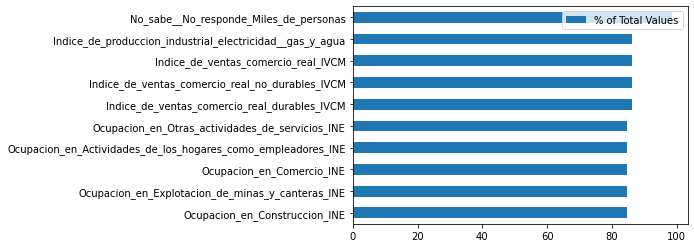

In [5]:
# Valores nulos indicadores económicos
# algunas columnas con valores nulos están completadas con 'a'. Por lo tanto reemplazamos los a por NaN
bc_df = bc_df.replace("a", np.nan).replace("", np.nan)

bc_df_missing = missing_values_table(bc_df)
bc_df_missing.iloc[:10].sort_values("% of Total Values", ascending=True).plot.barh(y="% of Total Values")
plt.plot()

## 2.2 Fomato de variables

Los datos númericos del banco central se encuentran en formato string separados por puntos. pero sin una escala determinada.
La escala numérica no se comparte necesariamente entre las columnas, ni siquiera entre valores de la misma columna.

Un ejemplo de esto es la columna 'Tipo_de_cambio_del_dolar_observado_diario' donde podemos observar valores de la forma: 519.25, pero también de la forma: 5.294.505. 

Por lo tanto, en virtud del tiempo, he decidido hacer uso del análisis realizado por Ana María Castillo Núñez,
actual miembro de Spike que participó en el desafío de Abril. (https://github.com/anacastillonu/desafio_spike_precios).

El procesamiento de los datos que realizo aquí está basado en el tratamiento que Ana María realizo mientras participaba en el desafío. Por lo tanto, la mayor parte del crédito se le debe a ella.

**pd: el repositorio lo encontré con una búsqueda cruzada entre LinkedIn y github**


Los indicadores los agrupamos en:
- IMACEC
- PIB
- Ocupación
- Índice de Producción Industrial
- Índice de ventas de comercio

### 2.2.1 IMACEC

In [6]:
# Numerizador
imacec_proc = ImacecProcessor()

# columnas Imacec
imacec_cols = [c for c in bc_df.columns if c.startswith("Imacec_")]


# numerización 
bc_df[imacec_cols] = imacec_proc.imacec_processing(bc_df[imacec_cols])

### 2.2.2 PIB

In [7]:
# Numerizador
pib_proc = PIBProcessor()

# columnas PIB
pib_cols = [c for c in bc_df.columns if c.startswith("PIB")] + ['Derechos_de_Importacion', 'Impuesto_al_valor_agregado']


# numerización
bc_df[pib_cols] = bc_df[pib_cols].apply(lambda col: pib_proc.pib_processing(col.values, col.name))

### 2.2.3 Commodities
- Gasolina
- Onza de Oro: Sin modificaciones
- Onza Plata
- Cobre
- diesel: sin modificaciones
- Gas natural
- Petróleo Brent: sin modificaciones
- Kerosene
- Petróleo WTI: sin modificaciones
- Propano: sin modificaciones

#### 2.2.3.1 Gasolina

In [8]:
# Numerizador
gasolina_proc = GasolinaProcessor()

# columnas Gasolina
gasolina_col = "Precio_de_la_gasolina_en_EEUU_dolaresm3"


# numerización 
bc_df[gasolina_col] = GasolinaProcessor().gasolina_processing(list(bc_df[[gasolina_col]].itertuples(name=None)))

#### 2.2.3.2 Onza de Plata

In [9]:
# Numerizador
onzaplata_proc = OnzaPlataProcessor()

# columnas Onza de la plata
onzaplata_col = "Precio_de_la_onza_troy_de_plata_dolaresoz"

# numerización
bc_df[onzaplata_col] = onzaplata_proc.onza_plata_processing(bc_df[onzaplata_col].values)

#### 2.2.3.3 Cobre

In [10]:
# Numerizador
cobre_proc = CobreProcessor()

# columna cobre
cobre_col = "Precio_del_cobre_refinado_BML_dolareslibra"

# numerización
bc_df[cobre_col] = cobre_proc.cobre_processing(bc_df[cobre_col].values)

#### 2.2.3.4 Gas natural

In [11]:
# Numerizador
gas_natural_proc = GasNaturalProcessor()

# columnas gas_natural
gas_natural_col = "Precio_del_gas_natural_dolaresmillon_de_unidades_termicas_britanicas"

# numerización
bc_df[gas_natural_col] = gas_natural_proc.gas_natural_processing(bc_df[gas_natural_col].values)

#### 2.2.3.5  Keroseno

In [12]:
# Numerizador
keroseno_proc = KerosenoProcessor()

# columnas keroseno
keroseno_col = "Precio_del_kerosene_dolaresm3"

# numerización
bc_df[keroseno_col] = keroseno_proc.keroseno_processing(bc_df[keroseno_col].values)

### 2.2.4 Tasas de cambio
- Observada
- Nominal multilateral

#### 2.2.4.1 Tasa Observada

In [13]:
# Numerizador
tasa_observada_proc = TasaObservadaProcessor()

# columnas tasa_observada
tasa_observada_col = "Tipo_de_cambio_del_dolar_observado_diario"

# numerización
bc_df[tasa_observada_col] = tasa_observada_proc.tasa_observada_processing(bc_df[tasa_observada_col].values)

#### 2.2.4.1 Tasa Nominal

In [14]:
# Numerizador
tasa_nominal_proc = TasaNominalProcessor()

# columnas tasa_nominal
tasa_nominal_col = "Tipo_de_cambio_nominal_multilateral___TCM"

# numerización
bc_df[tasa_nominal_col] = tasa_nominal_proc.tasa_nominal_processing(bc_df[tasa_nominal_col].values)

### 2.2.5 Ocupación

In [15]:
# Numerizador
ocu_proc = OcupacionProcessor()

# columnas Ocupación
ocu_cols = [c for c in bc_df.columns if c.startswith("Ocupa")] + ["No_sabe__No_responde_Miles_de_personas"]


# numerización
bc_df[ocu_cols] = bc_df[ocu_cols].apply(lambda col: ocu_proc.ocupacion_processing(col.values, col.name))

### 2.2.6 Indices

In [16]:
# Numerizador
indice_proc = IndiceProcessor()

# columnas indice
indice_cols = [c for c in bc_df.columns if c.startswith("Indice_")]


# numerización 
bc_df[indice_cols] = indice_proc.indice_processing(bc_df[indice_cols])

### 2.2.7 Energía

In [17]:
# Numerizador
energia_proc = EnergiaProcessor()

# columnas energia
energia_col = "Generacion_de_energia_electrica_CDEC_GWh"

# numerización
bc_df[energia_col] = energia_proc.energia_processing(bc_df[energia_col].values)

## 2.3 Valores duplicados

In [18]:
prep_df = drop_duplicates(prep_df, "date")
bc_df = drop_duplicates(bc_df, "Periodo")

DataFrame sin fechas duplicadas
Hay 2 fechas duplicadas
Filas completas repetidas. Se procede a eliminar 1


## 2.4 Descripción de las variables

### 2.4.1 Precipitaciones

In [19]:
prep_df.describe()

Coquimbo  Valparaiso  Metropolitana_de_Santiago  \
count  496.000000  496.000000                 496.000000   
mean    16.154691   32.450980                  49.666682   
std     32.629286   55.434330                  74.361099   
min      0.000000    0.000000                   0.000000   
25%      0.821521    1.538162                   5.297546   
50%      4.071036    9.037825                  19.087592   
75%     16.137600   38.409213                  63.408364   
max    347.133889  441.048604                 524.592667   

       Libertador_Gral__Bernardo_O_Higgins       Maule      Biobio  \
count                           496.000000  496.000000  496.000000   
mean                             72.249805   98.662773  128.113406   
std                             101.426112  122.766771  130.056094   
min                               0.000000    0.000000    0.001170   
25%                               5.343992   11.897363   29.356684   
50%                              25.995969   45.649888   79.558557   
75%                             101.875093  142.230716  184.751307   
max                             645.515752  759.177712  702.434707   

       La_Araucania    Los_Rios  
count    496.000000  496.000000  
mean     151.486456  199.451789  
std      126.628503  140.073615  
min        0.005331    0.748127  
25%       52.930343   89.805643  
50%      110.570990  159.467940  
75%      208.316243  274.594590  
max      661.211203  717.735673

### 2.4.2 Indicadores económicos 

In [20]:
bc_df.describe()

Imacec_empalmado  Imacec_produccion_de_bienes  Imacec_minero  \
count        298.000000                   298.000000     298.000000   
mean         808.973423                   876.556065     935.052347   
std          212.647409                   137.705831     103.477179   
min          453.518897                   572.892380     581.493448   
25%          601.518296                   764.895381     882.568833   
50%          803.261052                   879.033206     953.994217   
75%         1006.706488                   983.036087    1005.412130   
max         1223.477240                  1237.339180    1136.339120   

       Imacec_industria  Imacec_resto_de_bienes  Imacec_comercio  \
count        298.000000              298.000000       298.000000   
mean         867.612785              820.019037       722.554996   
std          132.414332              220.599389       286.208857   
min          583.677053              440.749973       324.521136   
25%          747.487682              640.700148       448.589894   
50%          879.864237              799.959585       657.254531   
75%          979.979117              965.466374       979.448236   
max         1124.605850             1415.043510      1372.345090   

       Imacec_servicios  Imacec_a_costo_de_factores  Imacec_no_minero  \
count        298.000000                  298.000000        298.000000   
mean         786.875556                  815.648171        790.459590   
std          250.859373                  206.667819        231.192887   
min          354.800099                  462.652930        421.567763   
25%          548.050017                  616.258642        560.219099   
50%          789.970566                  811.850911        783.143467   
75%         1019.436640                 1005.704567       1005.242245   
max         1239.021190                 1209.080880       1232.931390   

       PIB_Agropecuario_silvicola  ...  \
count                   93.000000  ...   
mean                   354.525985  ...   
std                    174.173859  ...   
min                    149.713225  ...   
25%                    209.516440  ...   
50%                    290.786889  ...   
75%                    533.636580  ...   
max                    704.614473  ...   

       Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100  \
count                                         418.000000       
mean                                          951.685527       
std                                            86.154937       
min                                           752.652313       
25%                                           902.937552       
50%                                           944.051154       
75%                                          1005.030115       
max                                          1159.017170       

       Indice_de_produccion_industrial  \
count                       142.000000   
mean                        973.235812   
std                          59.417167   
min                         796.396317   
25%                         938.880587   
50%                         978.957438   
75%                        1013.785845   
max                        1112.521440   

       Indice_de_produccion_industrial__mineria  \
count                                370.000000   
mean                                 772.409938   
std                                  230.691079   
min                                  263.895917   
25%                                  616.864432   
50%                                  843.161390   
75%                                  950.362857   
max                                 1143.774990   

       Indice_de_produccion_industrial_electricidad__gas_y_agua  \
count                                          82.000000          
mean                                         1051.167659          
std                                            44.239353          
min                              

## 2.5 Distribución de variables

### 2.5.1 Precipitaciones

En el boxplot a continuación podemos ver como los mm de agua precipitada aumentan a media que vamos más al sur del país, así como su varianza y rango de valores.

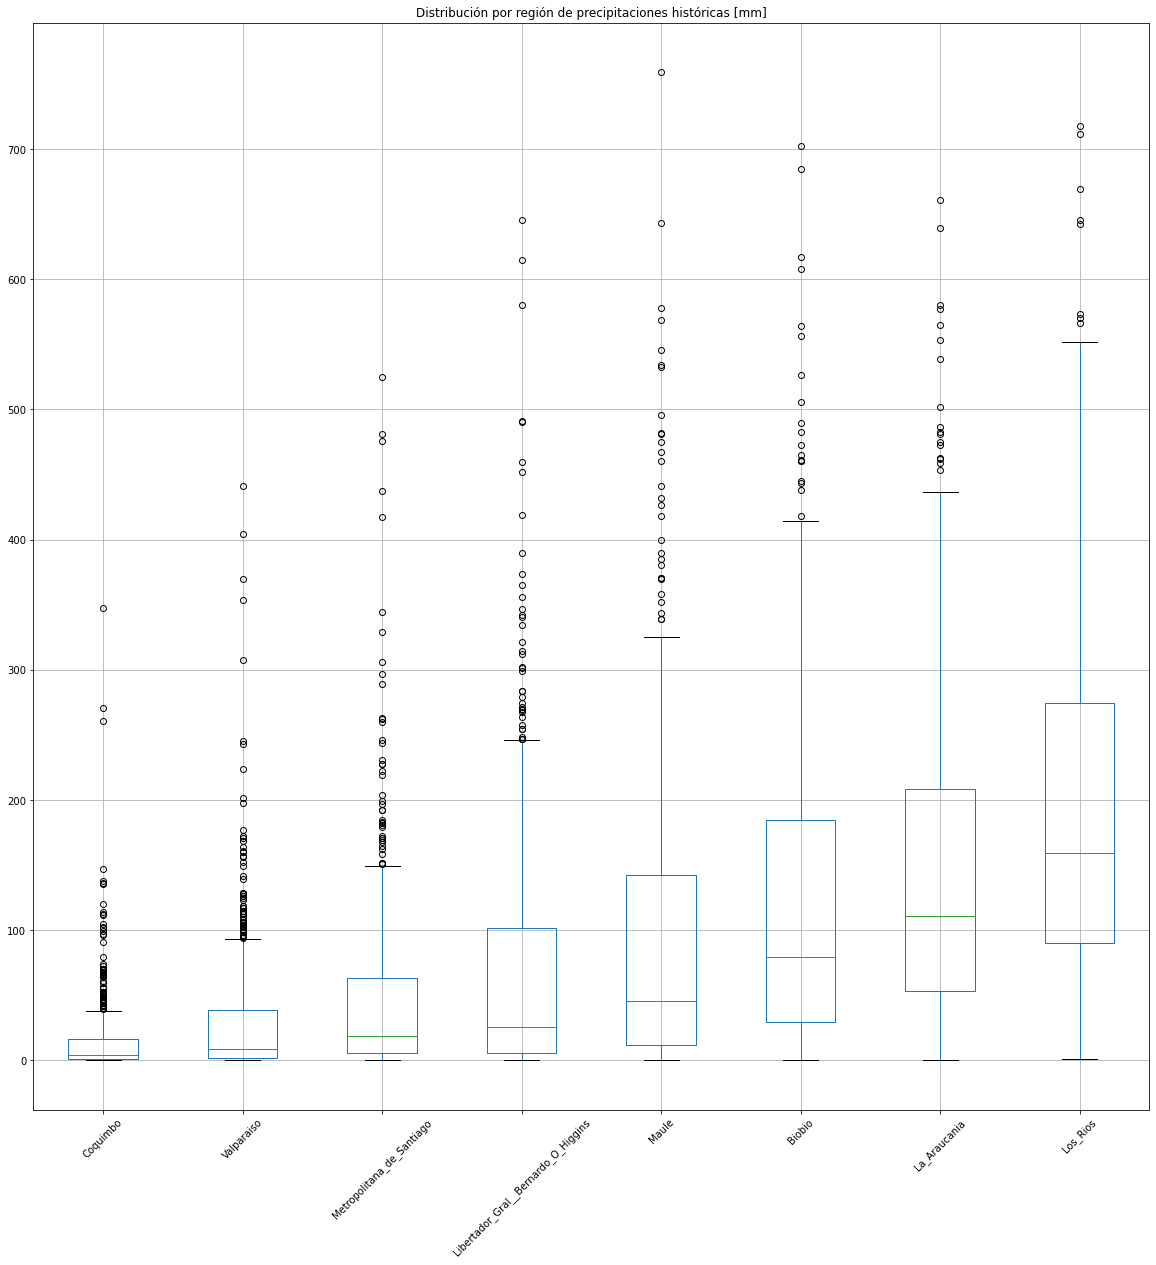

In [21]:
prep_df.boxplot(figsize=(20,20))
plt.title("Distribución por región de precipitaciones históricas [mm]")
plt.xticks(rotation=45)
plt.show()

### 2.5.1 Indicadores económicos 

Los siguientes gráficos muestran la distribución estandariza por el promedio y la desviación estandar observada de los indicadores económicos.

los gráficos están agrupados según la agrupación de variables que se realizo en la sección 2.2.

De simple observación podemos inferir que los datos se alejan de una distribución normal. Hay mucha variabilidad incluso entre variables de la misma categoría y las distribuciones no son necesariamente simétricas, ni centradas en el promedio.

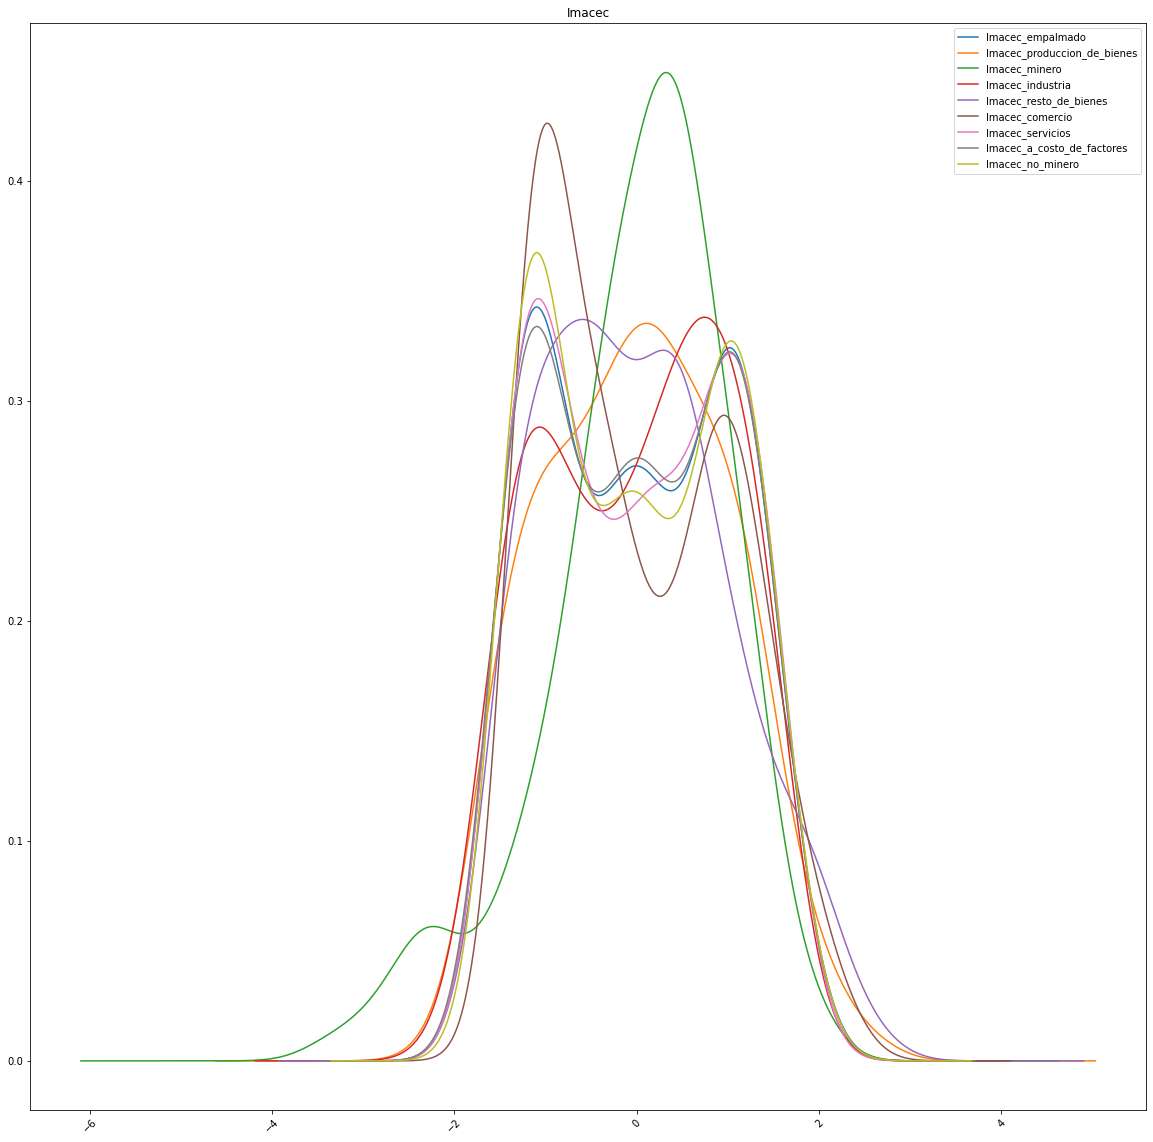

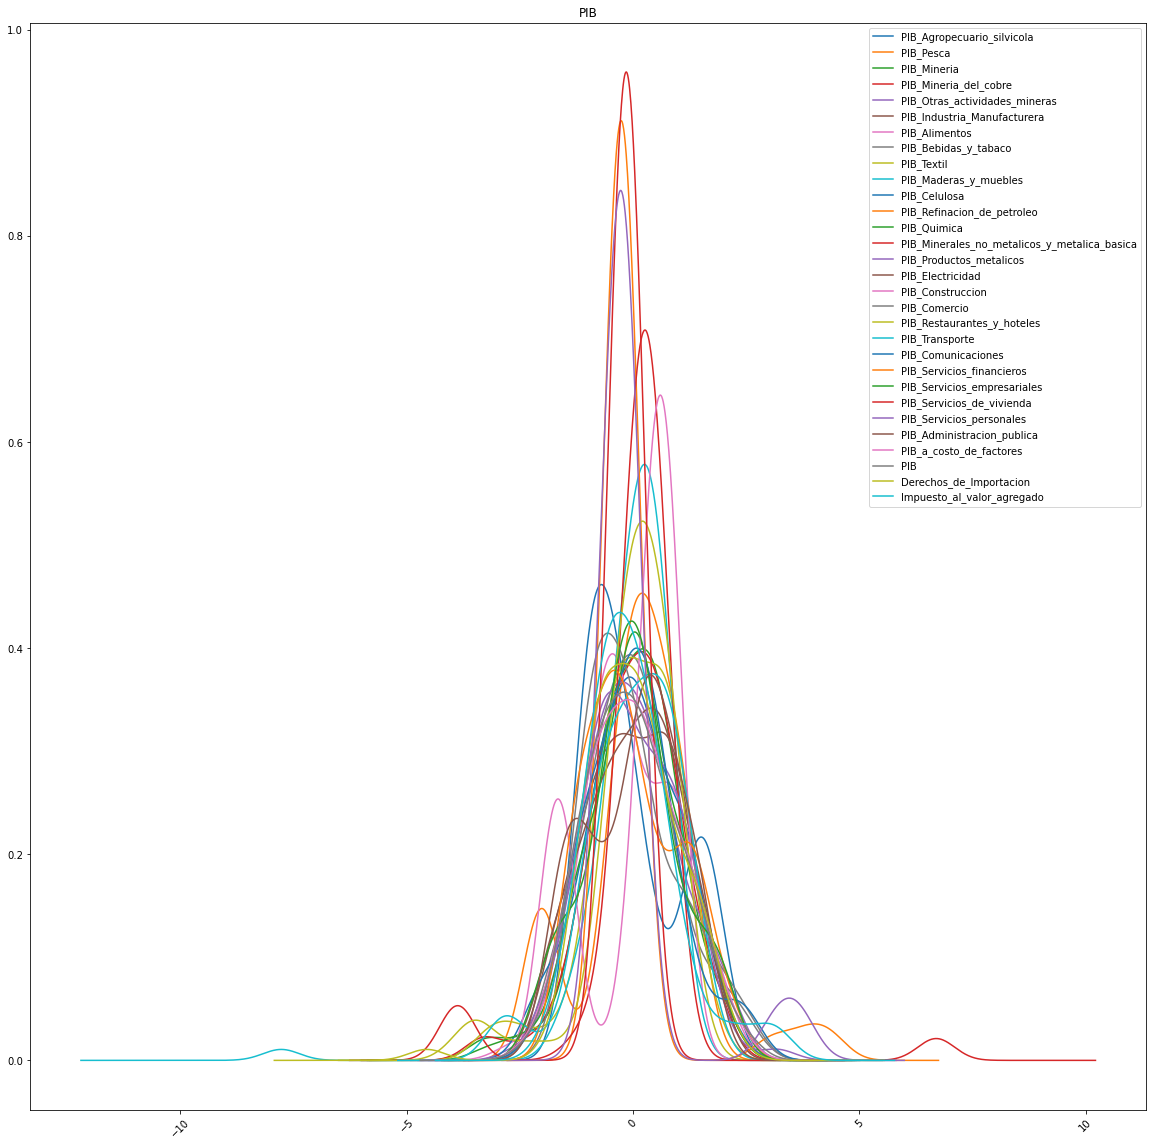

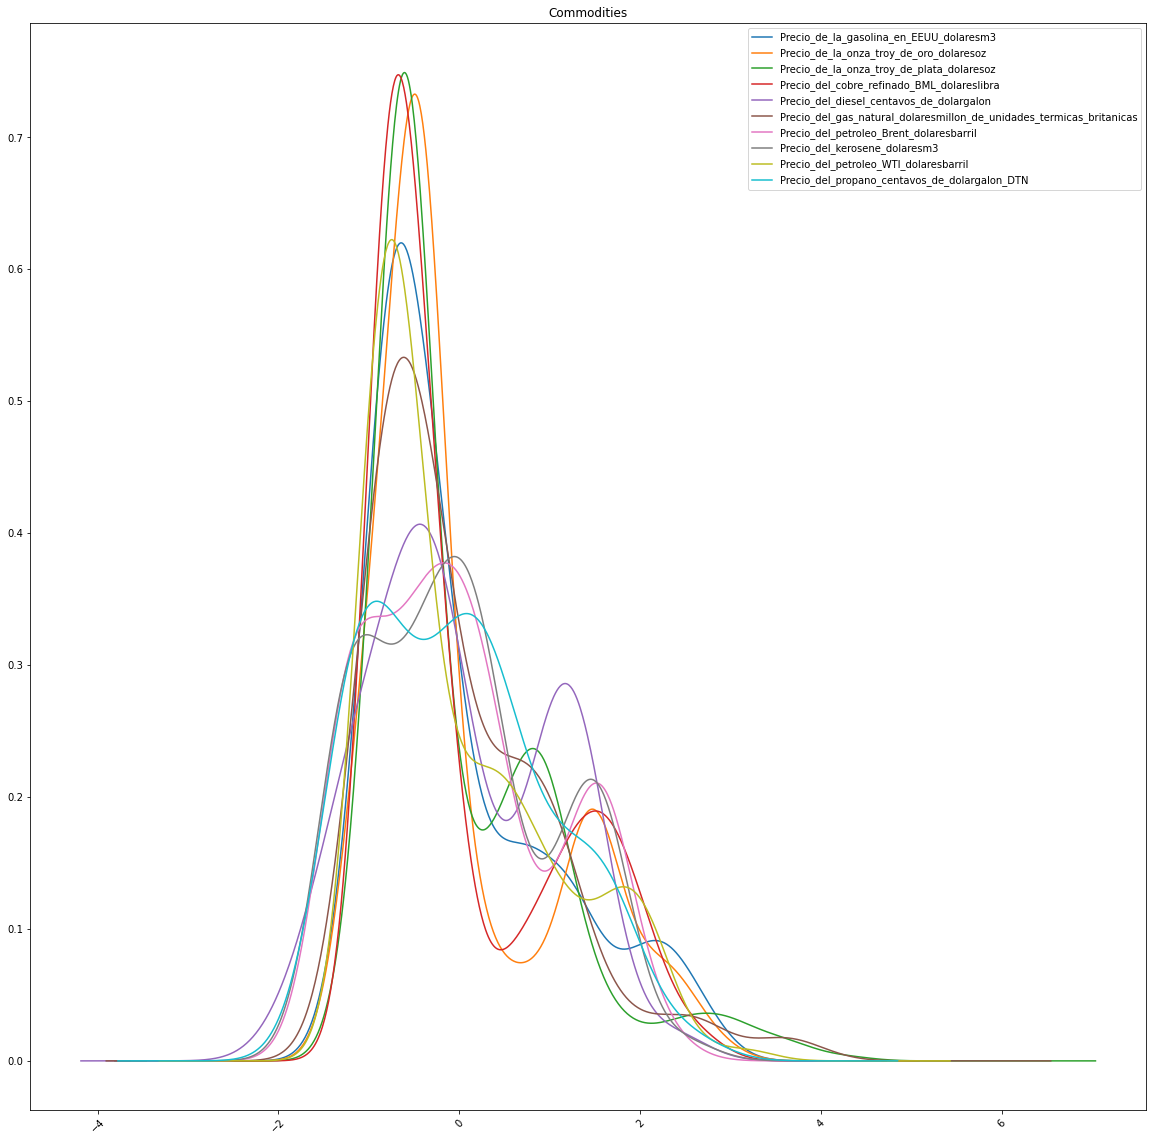

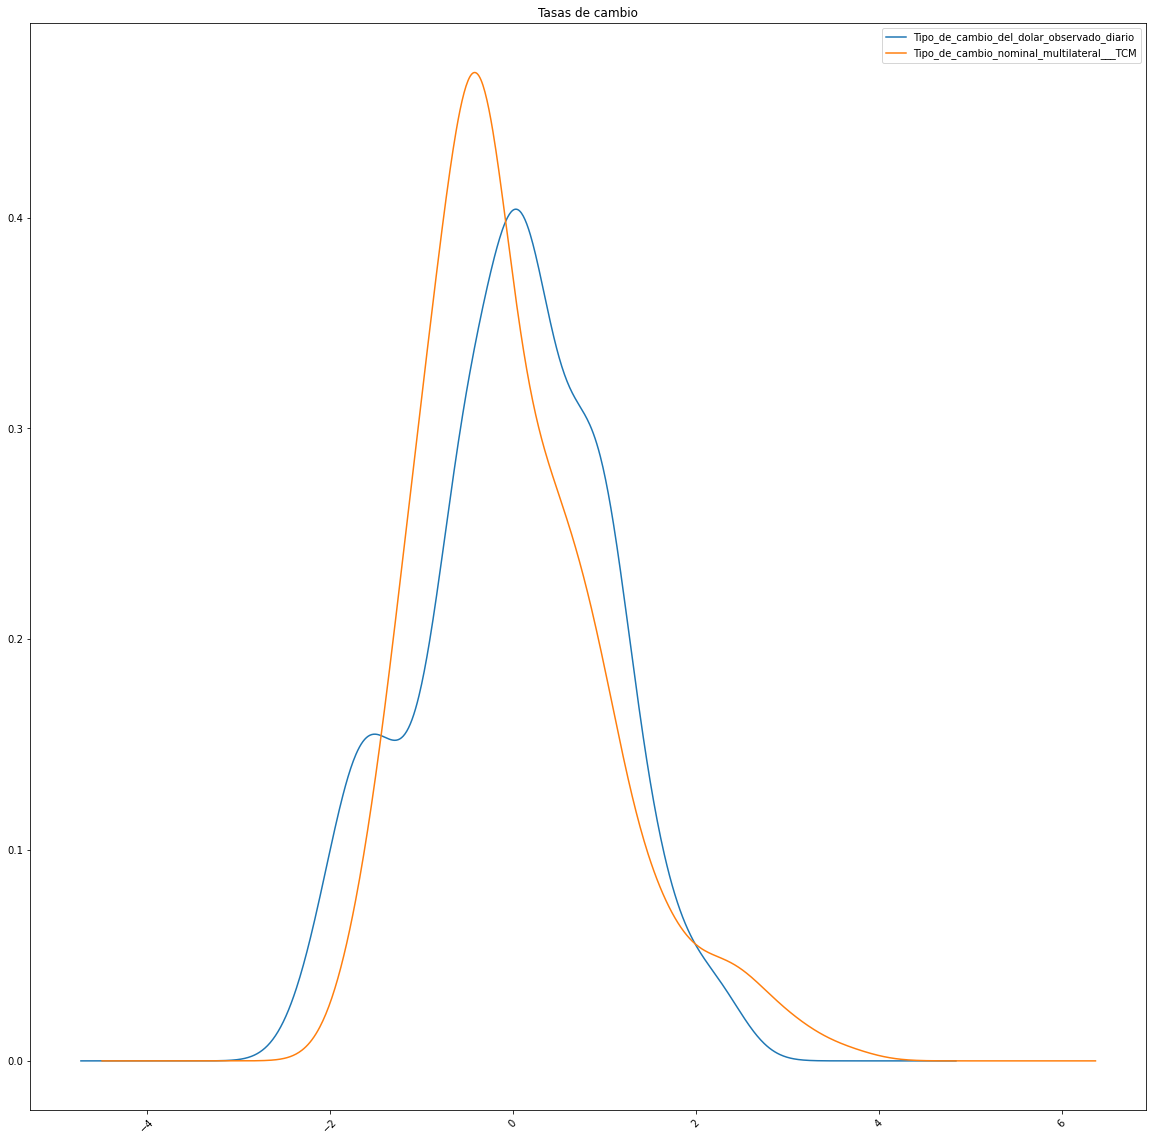

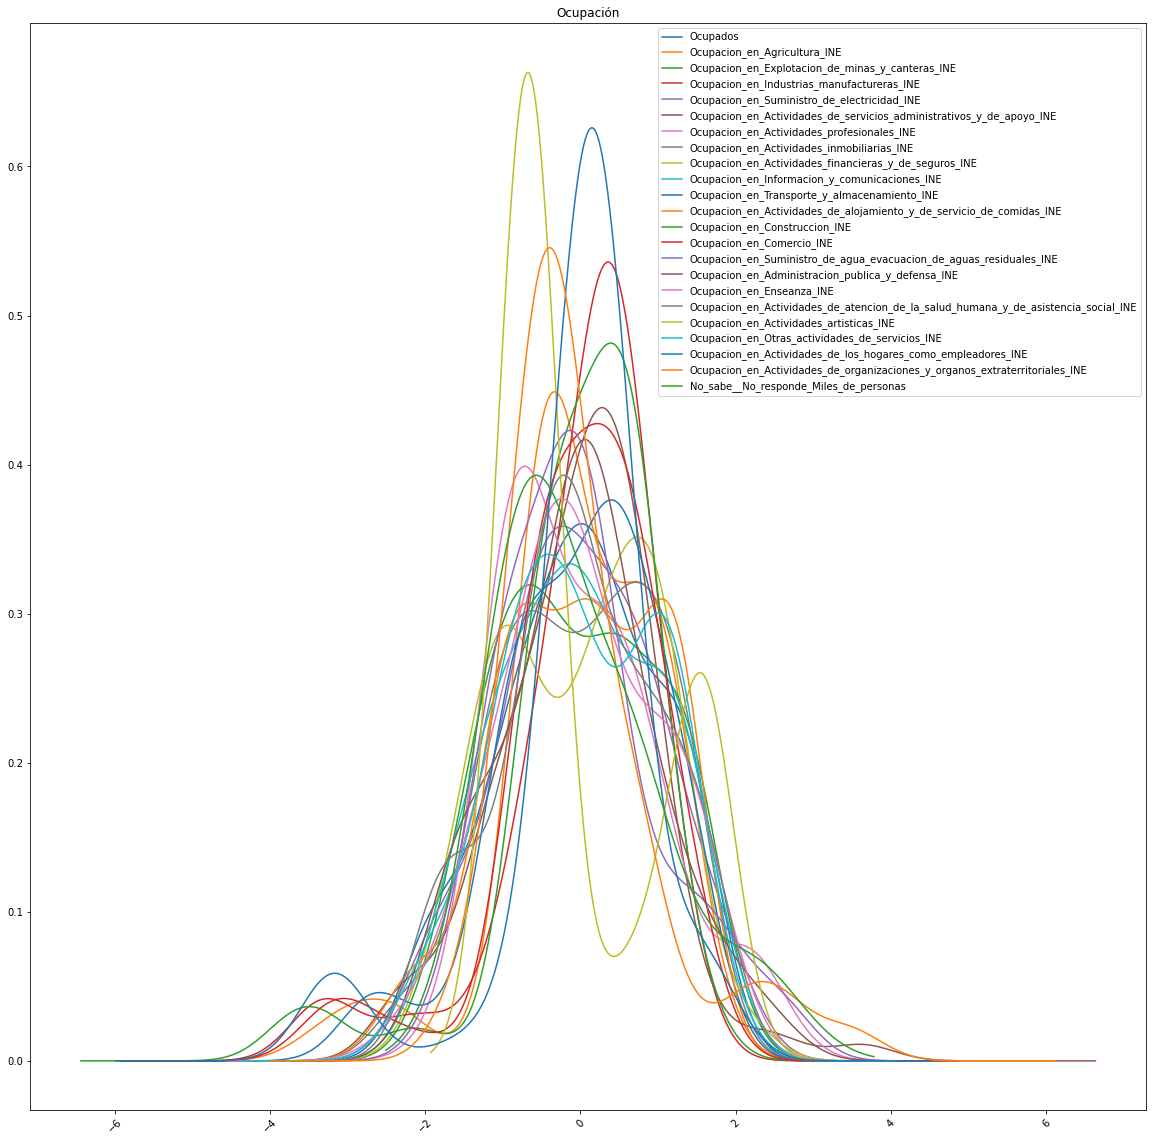

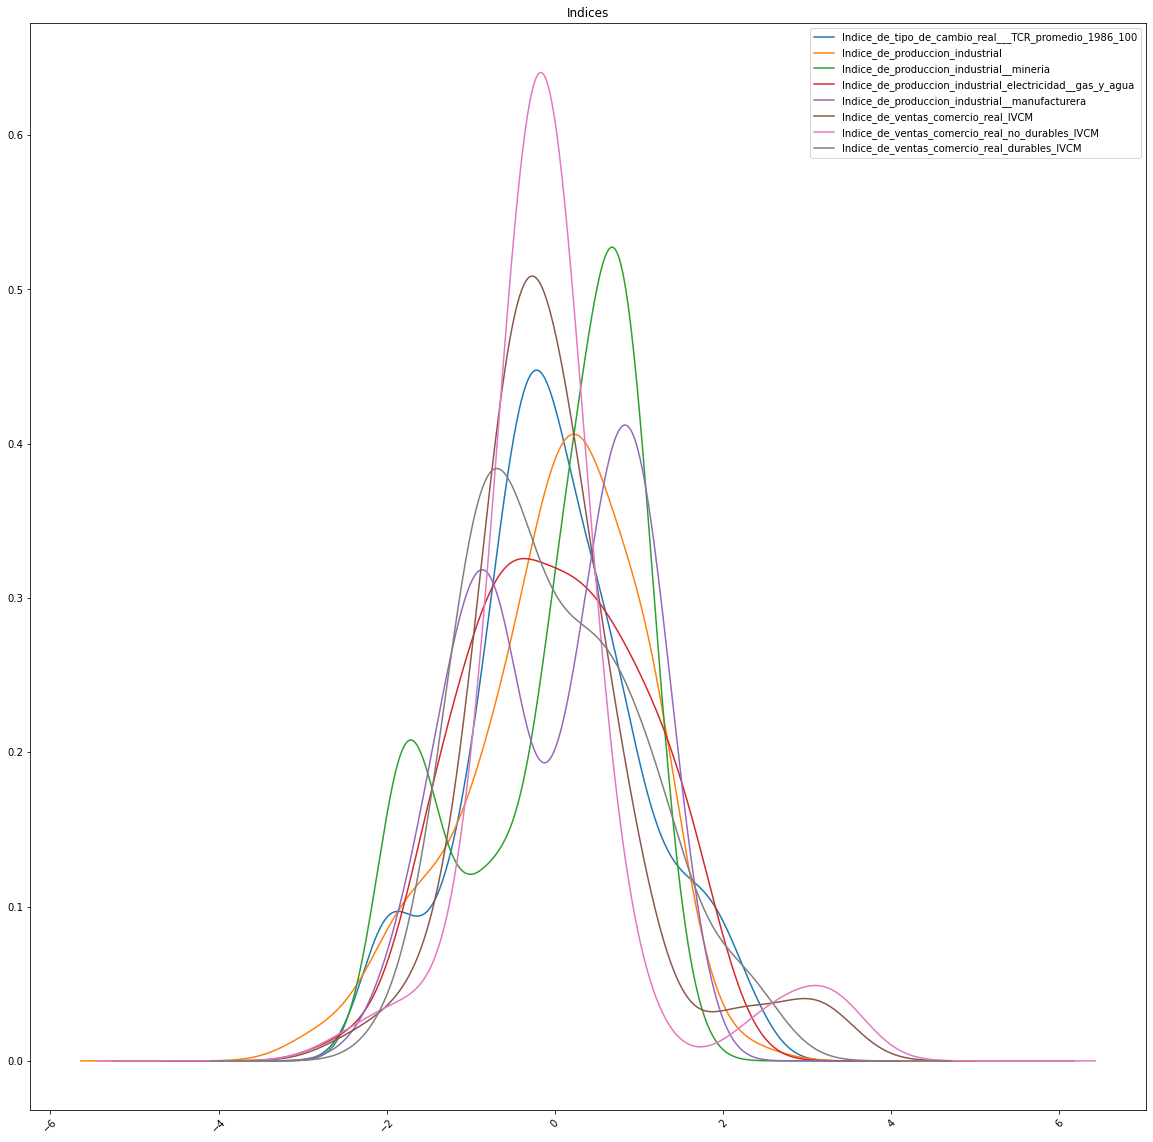

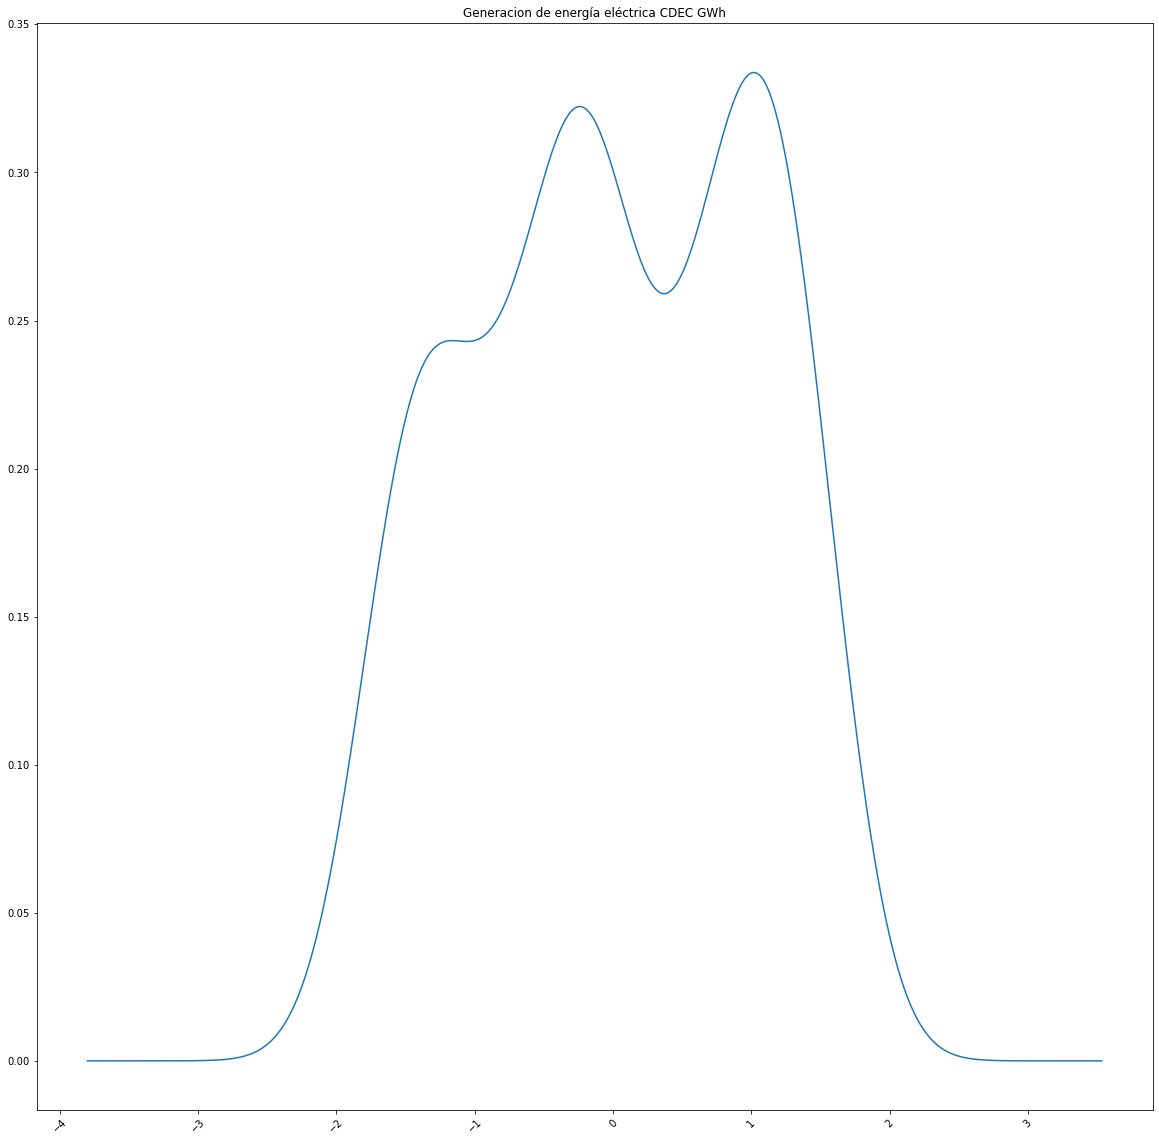

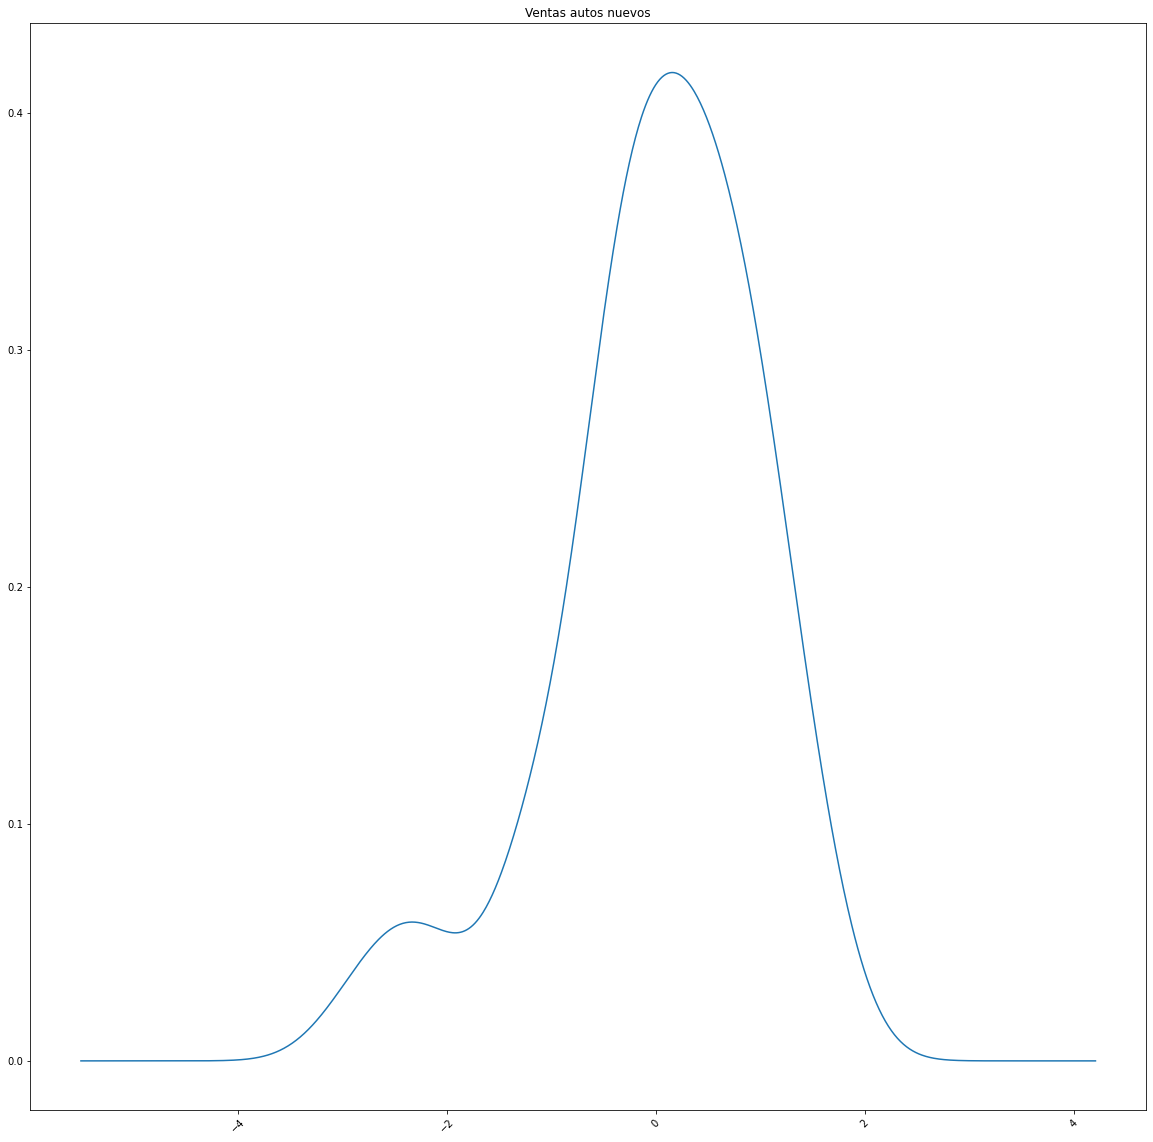

In [22]:
# Distribución imacec
distribution_plots(bc_df[imacec_cols], title="Imacec")

# Distribución PIB
distribution_plots(bc_df[pib_cols], title="PIB")

# Distribución commodities
commodities_cols = [gasolina_col,
                    "Precio_de_la_onza_troy_de_oro_dolaresoz", 
                    onzaplata_col, cobre_col,
                   'Precio_del_diesel_centavos_de_dolargalon',
                   gas_natural_col,
                   'Precio_del_petroleo_Brent_dolaresbarril',
                   keroseno_col,
                   'Precio_del_petroleo_WTI_dolaresbarril',
                   'Precio_del_propano_centavos_de_dolargalon_DTN',
                   ]
distribution_plots(bc_df[commodities_cols], title="Commodities")


# Distribución tasas de cambio
tasas_col = [tasa_observada_col, tasa_nominal_col]
distribution_plots(bc_df[tasas_col], title="Tasas de cambio")

# Distribución Ocupación
distribution_plots(bc_df[ocu_cols], title="Ocupación")

# Distribución indices
distribution_plots(bc_df[indice_cols], title="Indices")

# Distribución energía
distribution_plots(bc_df[energia_col], title="Generacion de energía eléctrica CDEC GWh")

# Distribución autos
distribution_plots(bc_df["Ventas_autos_nuevos"], title="Ventas autos nuevos")

## 2.6 Correlación entre indicadores económicos

El siguiente mapa de calor permite tener una idea visual de la correlación entre las variables.
El grupo de variables IMACEC tiene una fuerte correlación entre sí y con otras variables. Lo mismo pasa con los commodities.

Una alta correlación entre variables puede llevar a una multicolinealidad que entorpece los resultados de un modelo predictivo lineal.

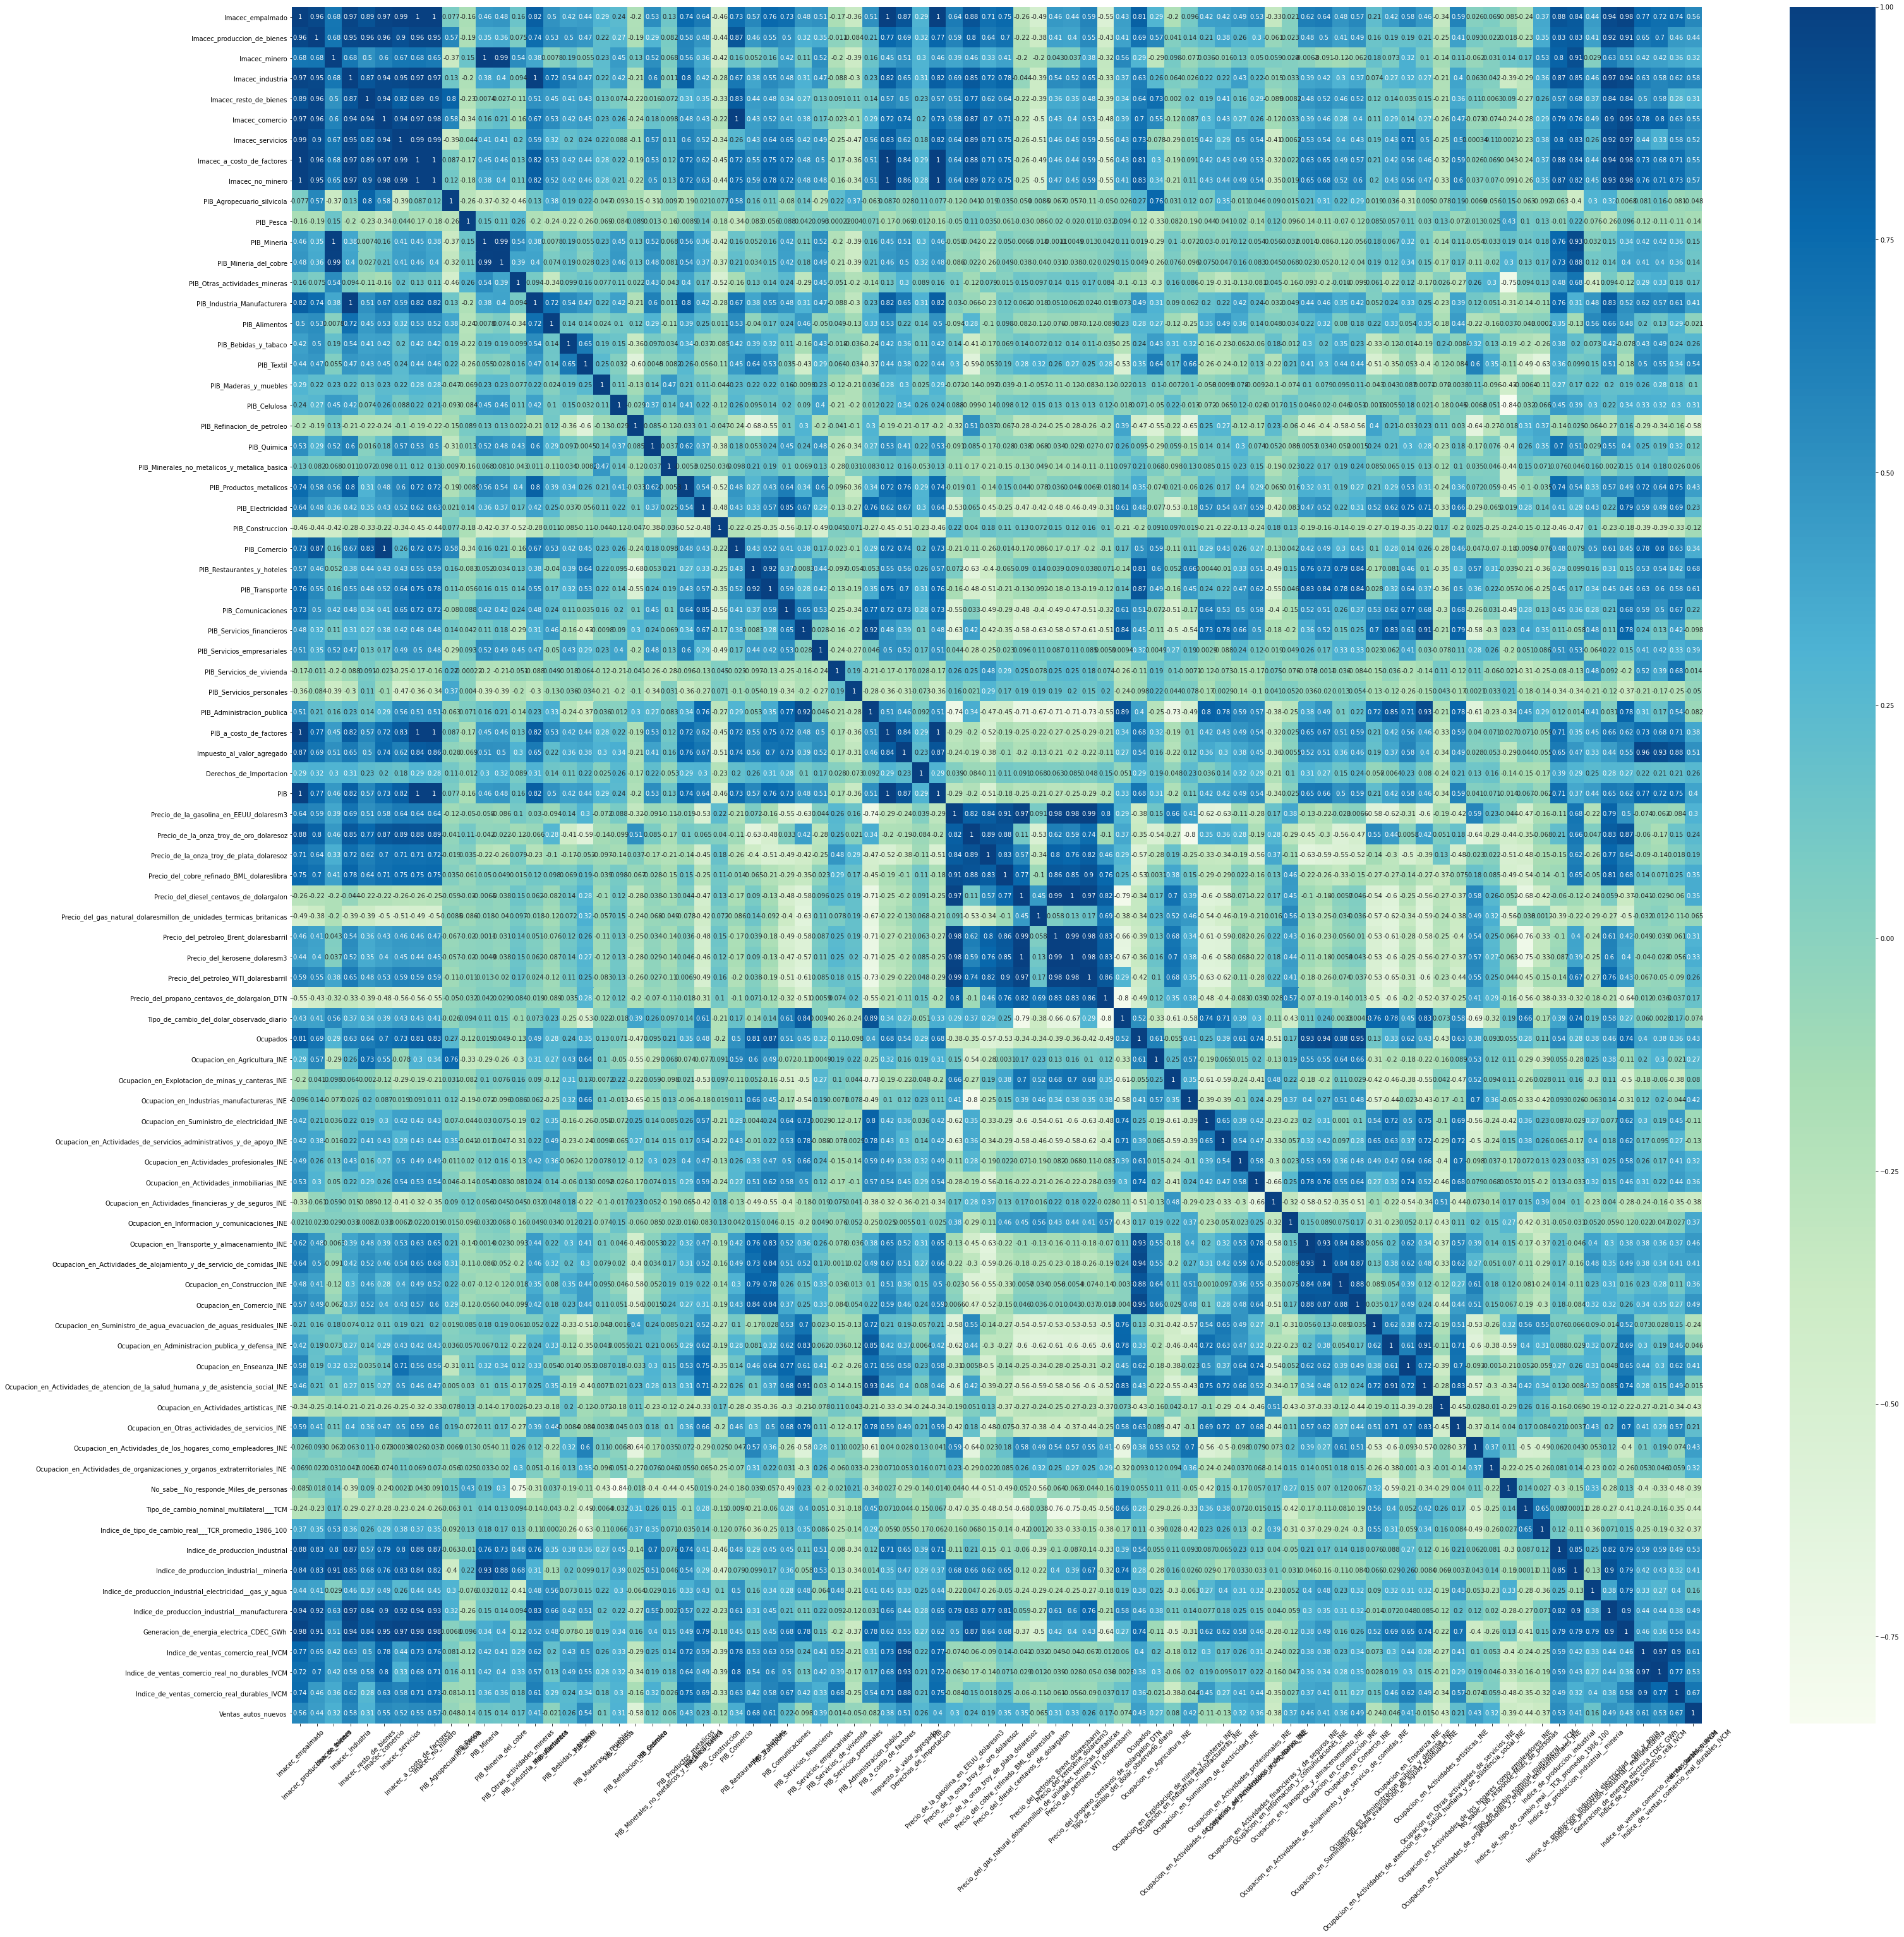

In [23]:
corr_heatmap(bc_df)

# 3 Visualización

## 3.1 Precipitaciones históricas

Por simple observación podemos inferir sesionalidad en los períodos de lluvia. En los caso de ejemplo, podemos ver cómo en la región de O'Higgins hay más mm de precipitación históricamente que en la región Metropolitana (normal dado que se encuentra más al sur del país como lo graficó el boxplot de la sección 2.5.1)


Fechas dentro del rango de fechas del conjunto de datos


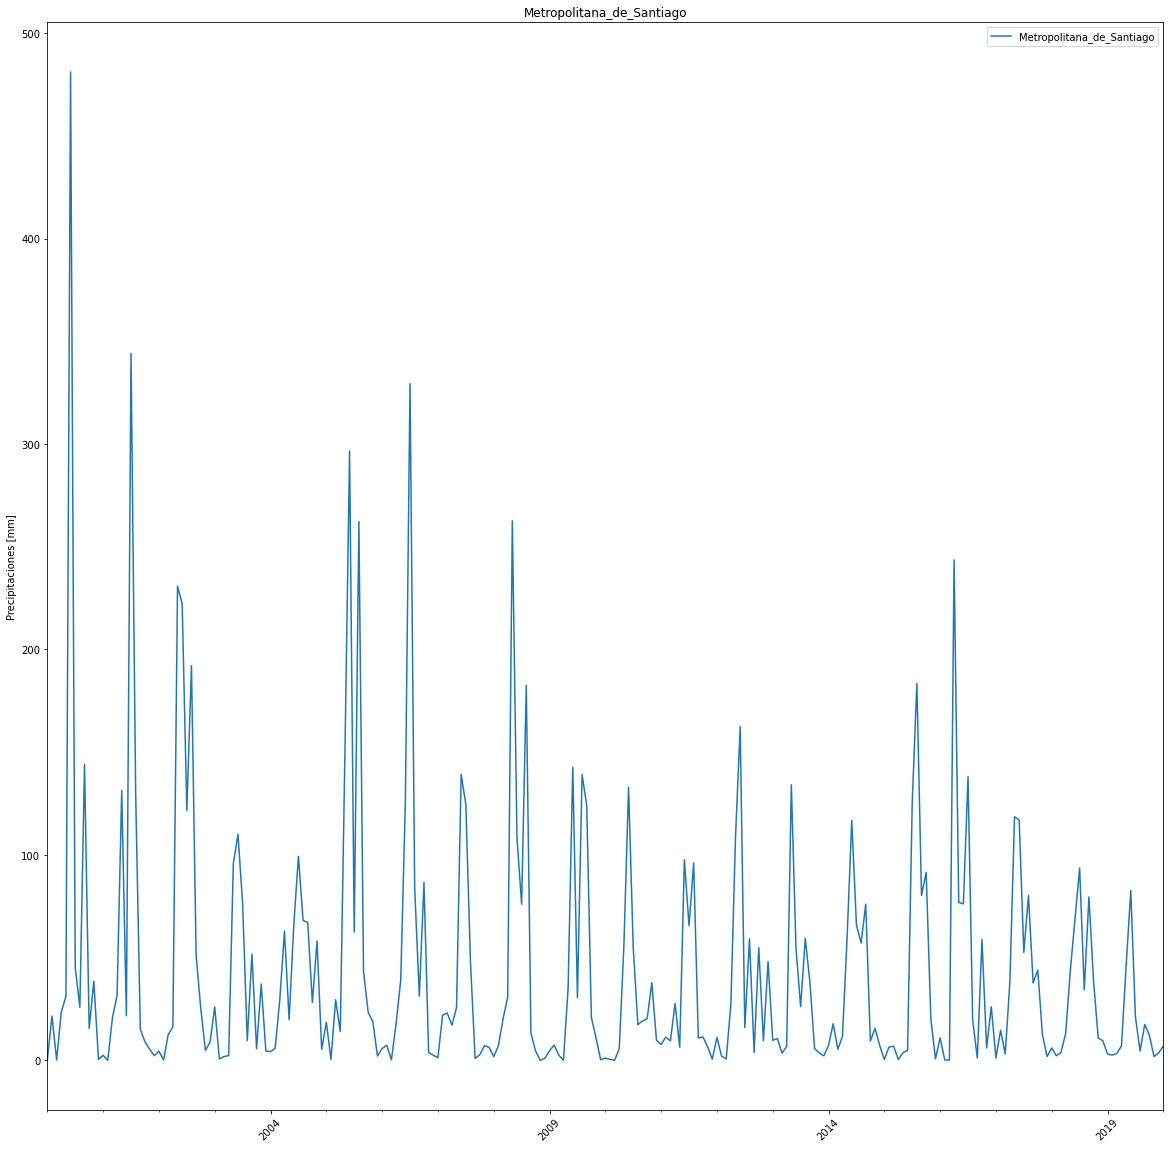

Fechas dentro del rango de fechas del conjunto de datos


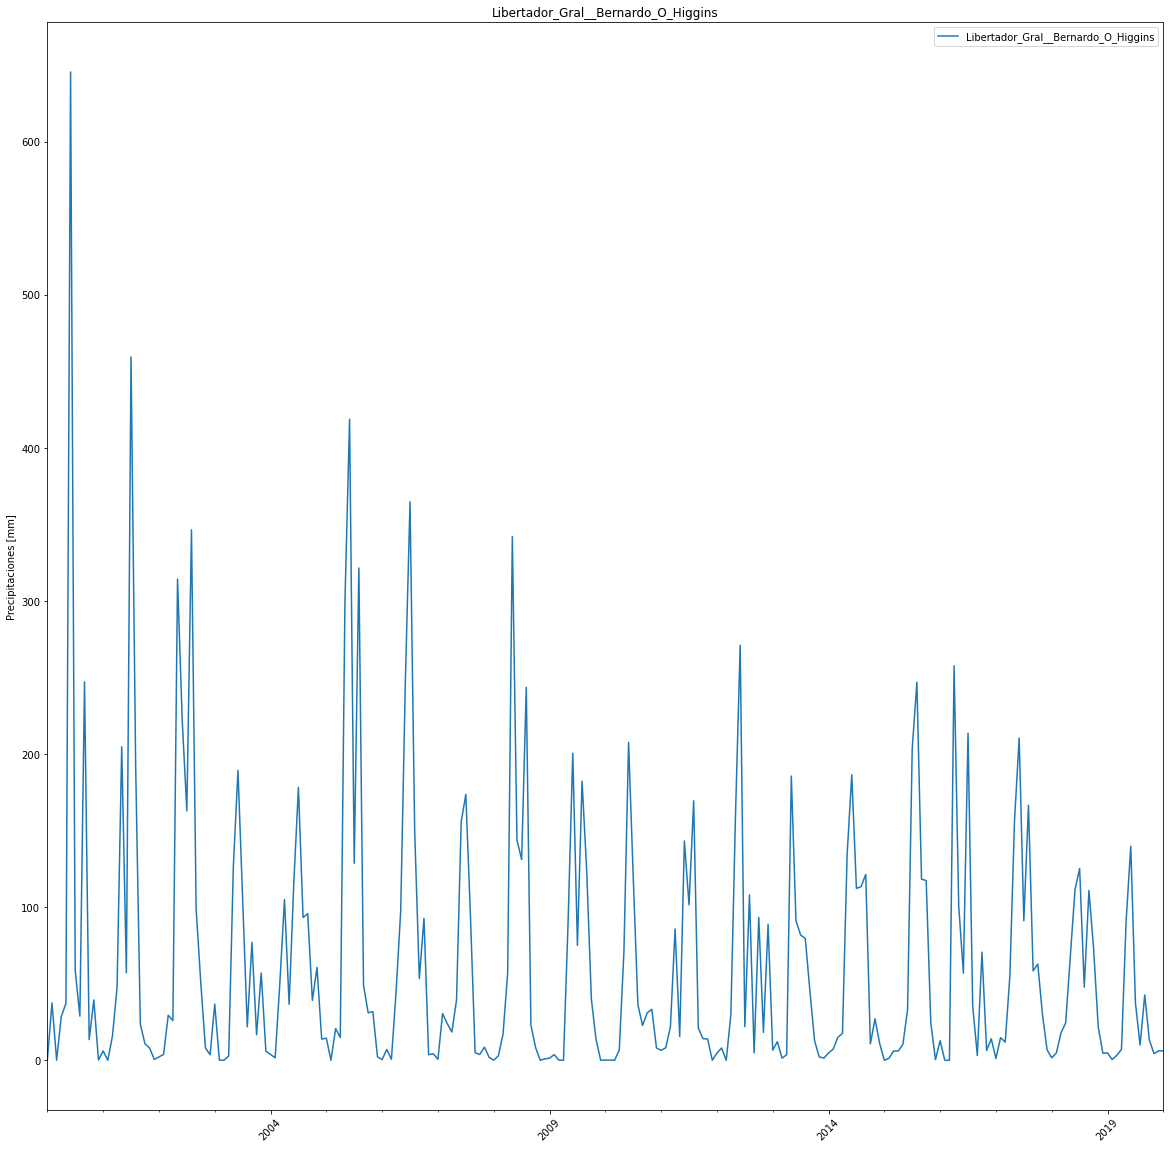

In [24]:
plot_prep = lambda region, start_date, end_date: plot_precipitaciones(region, start_date, end_date, prep_df)


start_date = pd.Timestamp(year=2000, month=1, day=1)
end_date = pd.Timestamp(year=2020, month=1, day=1)

plot_prep('Metropolitana_de_Santiago', start_date , end_date)

plot_prep('Libertador_Gral__Bernardo_O_Higgins', start_date , end_date)

## 3.2 Precipitaciones mensuales

En la siguiente gráfica se muestran las precipitaciones por mes de los años seleccionados. Acorde al sentido común nos encontramos con mayor cantidad de agua, medida en mm, en los meses de invierno. 

Sin embargo, al pasar el tiempo la cantidad de mm precipitada disminuye. Desde una precipitación máxima superior a 500 mm de agua en 1982 a una cercana a los 200 mm en 2019, podemos ver como cada año se reduce la cantidad de mm de agua precipitados. 

Esto junto con los gráficos anteriores son indicios de un cambio climático. No es secreto que hace años Chile sufre de sequía.

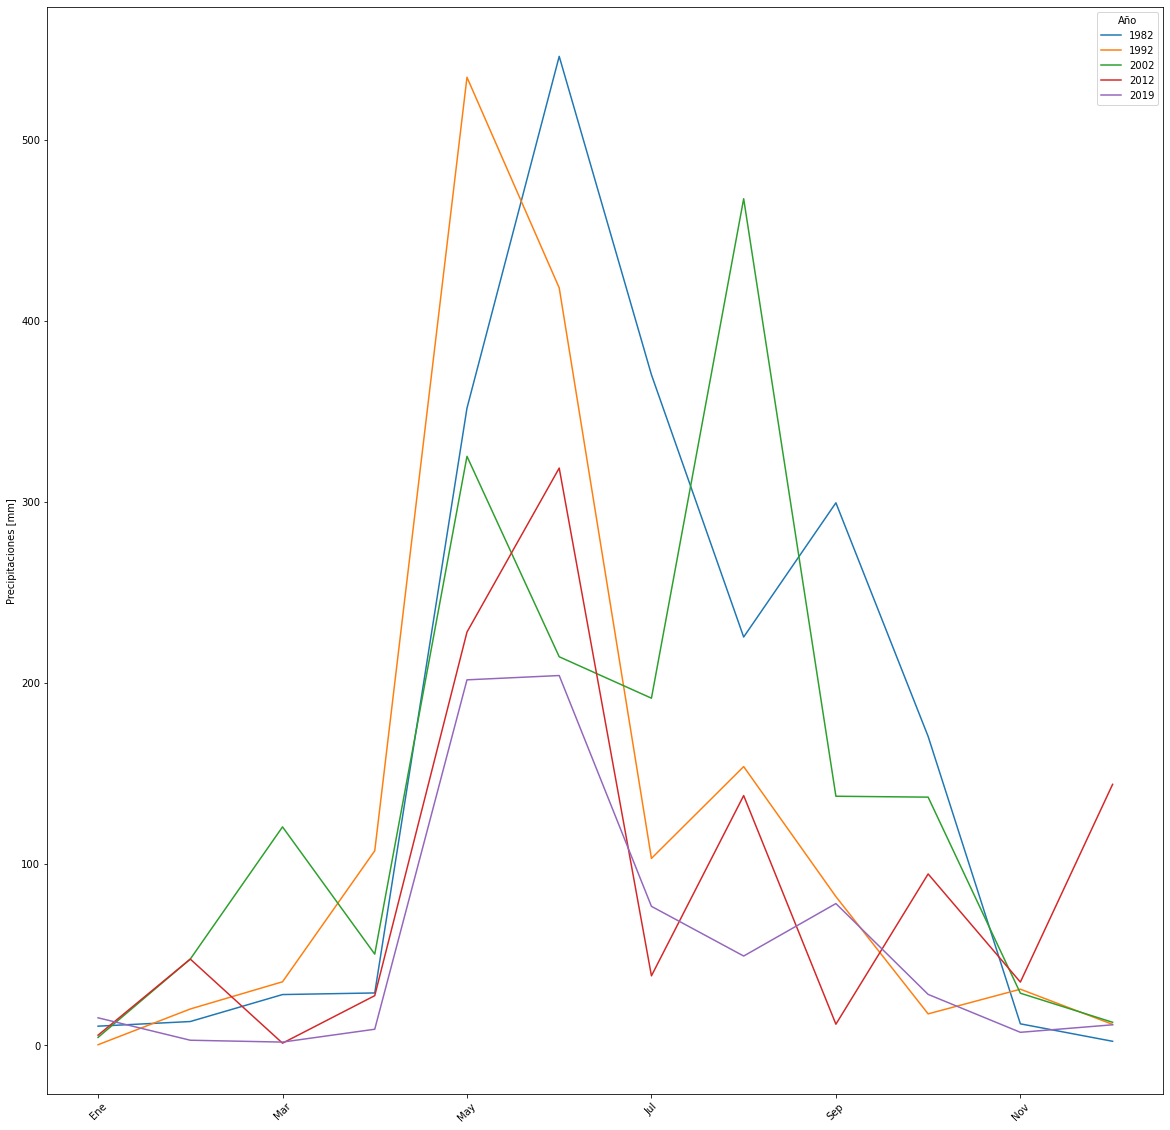

In [25]:
plot_prep_mensual = lambda region, years: plot_precipitaciones_mensuales(region, years, prep_df)

region = "Maule"
years = [1982,1992,2002,2012,2019]

plot_prep_mensual(region, years)

## 3.3 PIBs agropecuario silvicola y de servicios financieros

Observamos que el PIB agropecuario silvicola se comporta de manera estacional. Esto está ligado a las restricciones físicas propias de estos tipos de comercios. Tanto el ganado como la agricultura pasan por perídos de siembra (cría y desarrollo de ganado) como se cosecha.

Respecto al PIB de servicios financieros, podemos observar una tendencia alcista en los años seleccionados. No es de extrañarse, dado que la industria financiera es un pilar clave en la economía contemporánea.

También podemos observar que los peaks del PIB agropecuario y silvicola calzan con los peaks del PIB de los servicios financieros. Esto puede ser a mayor demanda de servicios financieros desde la industria agropecuria en momentos claves de su desarrollo

Fechas dentro del rango de fechas del conjunto de datos


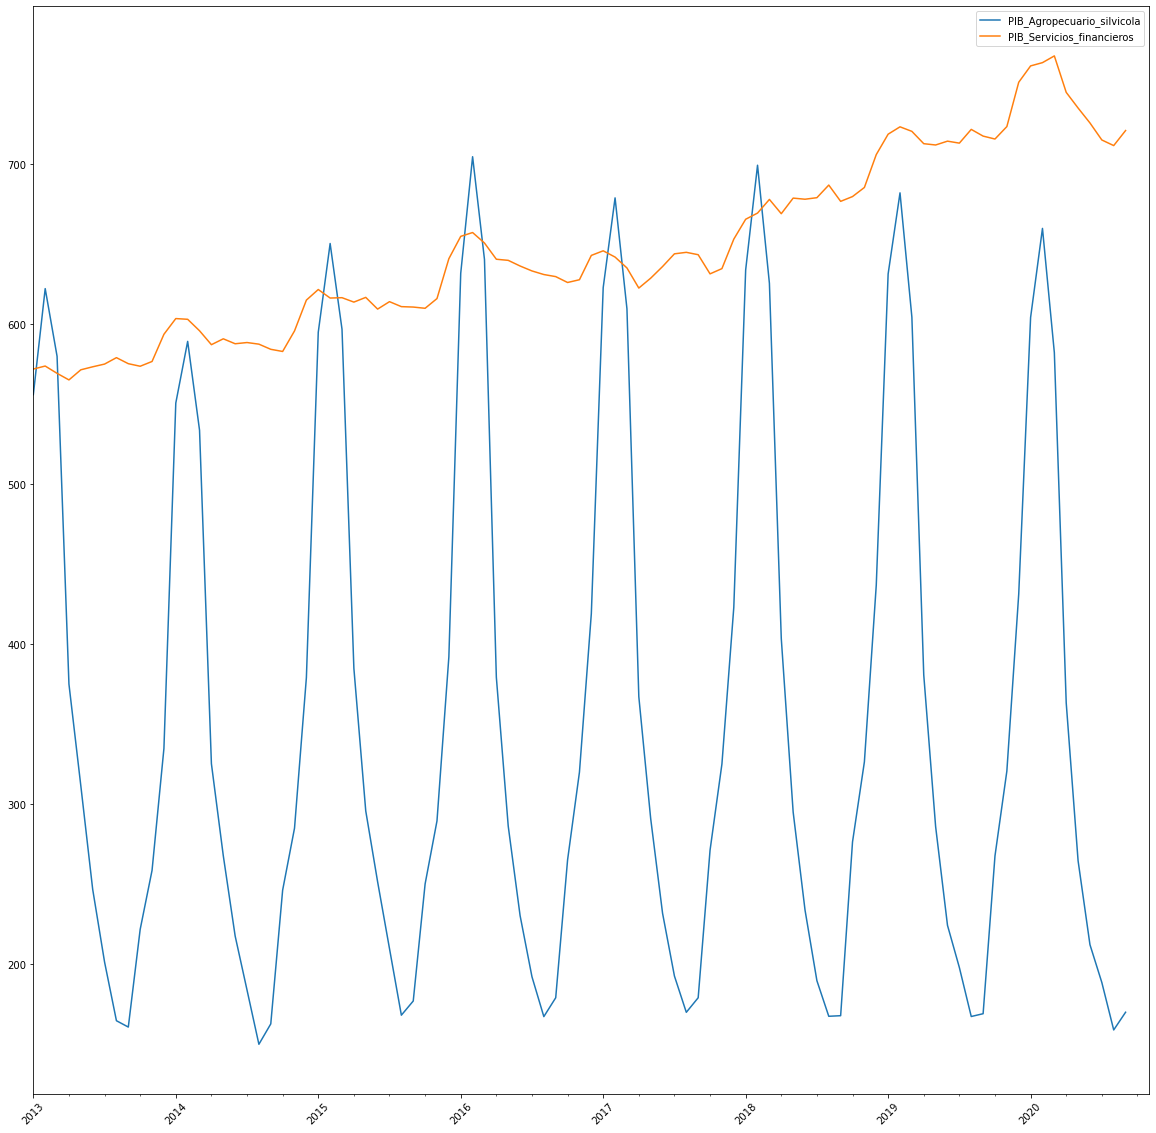

In [26]:
plot_pib = lambda pib_names, start_date, end_date: plot_pibs(pib_names, start_date, end_date, bc_df)

start_date = pd.Timestamp(year=2013, month=1, day=1)
end_date = np.max(bc_df.index)
plot_pib(['PIB_Agropecuario_silvicola', 'PIB_Servicios_financieros'], start_date, end_date)

# 4 Tratamiento y creación de variables

## 4.1 Conjunto de datos target: precios historicos de la leche

In [27]:
leche_df = pd.read_csv(os.path.join("datasets","precio_leche.csv"))
leche_df["Mes_num"] = leche_df["Mes"].apply(lambda row: nombre_mes(row, True))
leche_df["date"] = leche_df.apply(lambda row: pd.Timestamp(year=row["Anio"], month=row["Mes_num"], day=1), axis=1)
leche_df = drop_duplicates(leche_df, "date").sort_values("date").set_index("date")

leche_df

DataFrame sin fechas duplicadas


Anio  Mes  Precio_leche  Mes_num
date                                        
1979-01-01  1979  Ene          3.85        1
1979-02-01  1979  Feb          4.58        2
1979-03-01  1979  Mar          5.18        3
1979-04-01  1979  Abr          6.06        4
1979-05-01  1979  May          7.25        5
...          ...  ...           ...      ...
2020-10-01  2020  Oct        274.32       10
2020-11-01  2020  Nov        288.09       11
2020-12-01  2020  Dic        287.29       12
2021-01-01  2021  Ene        287.60        1
2021-02-01  2021  Feb        295.24        2

[506 rows x 4 columns]

## 4.2 Dataset

El dataset consiste en la unión de los datos de precipitaciones, indicadores económicos y de precios de la leche

Dado que los datos están indexados por las fechas, un simple pd.concat los une como si fuera un .join("outer") y es mucho más eficiente que un pd.merge


Dado que el target es el precio de la leche para el mes siguiente, usamos la función de pandas .shift() para dejar por fila como target el valor del precio de la leche del mes siguiente. Si no se conoce dicho valor, esa columna es eliminada del dataset.

Finalmente, separamos entre features y target las columnas del dataset


In [28]:
# unir indicadores económicos con precipitaciones
dataset = pd.concat([prep_df, bc_df], axis=1)

# unir con datos de la leche
dataset = pd.concat([dataset, leche_df], axis=1)

dataset = dataset.sort_index()

# variables: Año, Mes, Trimestre
dataset["Anio"] = dataset.index.year
dataset["Mes"] = dataset.index.month
dataset["Trimestre"] = dataset.index.quarter


# definiendo el target: precio leche mes siguiente
dataset = dataset.reset_index()
dataset["Target"] = dataset["Precio_leche"].shift(-1)
dataset["date_sig"] = pd.to_datetime(dataset["index"].shift(-1))
dataset = dataset[:-1]
dataset["is_nextmonth"] = dataset.apply(lambda row: next_month(row["index"])==row["date_sig"], axis=1)

dataset = dataset[dataset["is_nextmonth"]].drop(["date_sig", "is_nextmonth"],axis=1).set_index("index")

dataset = dataset[dataset["Target"].notna()]


In [29]:
# features y target
#X = dataset.drop(["Precio_leche", "Target", "Anio"], axis=1)
X = dataset.drop(["Target"], axis=1)

y = dataset["Target"]


# 4.3 Correlación variables predictivas con target

El precio de la leche está fuertemente correlacionado con el precio del mes anterior, el año, algunas variables IMACEC, la generación de energía eléctrica y el indice de producción industrial manufacturera.

Sin embargo, posee baja correlación con las variables trimestre y mes. Lo que podría indicar que el comercio de la leche es un comercio inelástico y que su precio se debe más a factores internos, o que la demanda permanece constante a lo largo del año.

Que el precio de la leche del mes anterior sea la variable con mayor correlación, incluso cercana a 1 puede indicar que la serie de tiempo del precio de la leche es autoregresiva

In [30]:
corr_target = dataset.corr()["Target"].drop("Target").sort_values(ascending=False).to_frame()
corr_target

Target
Precio_leche                                        0.997943
Anio                                                0.973735
Imacec_servicios                                    0.914080
Generacion_de_energia_electrica_CDEC_GWh            0.914004
Imacec_no_minero                                    0.912522
...                                                      ...
Precio_del_gas_natural_dolaresmillon_de_unidade... -0.448805
PIB_Restaurantes_y_hoteles                         -0.512507
PIB_Textil                                         -0.628664
Ocupacion_en_Actividades_de_los_hogares_como_em... -0.668956
Ocupacion_en_Industrias_manufactureras_INE         -0.705564

[97 rows x 1 columns]

In [31]:
corr_target.loc["Trimestre"]

Target   -0.017823
Name: Trimestre, dtype: float64

In [32]:
corr_target.loc["Mes"]

Target   -0.019259
Name: Mes, dtype: float64

# 5. Modelo

## 5.1 XGBoost

El modelo elegido es el XGBoost, un modelo de la categoría "ensemble" que utiliza como predictor de base árboles de decisión. Este potente algorítmo posee ciertas propiedades que me hicieron elegirlo para este problema:

- Permite manejar no linealidades: Como se nombró anteriormente, muchas variables predictivas están muy correlacionadas entre sí. Para evitar que la colinealidad sea un problema, se descarta un modelo lineal. Además, así nos evitamos una pre etapa de selección de variables
- Puede manejar valores nulos: En un dataset tan pequeño (~500 ejemplo) como el nuestro, no podemos darnos el lujo de perder filas enterar y/o columnas debido a los valores nulos. Imputar estos valores podría llevar a predicciones erronéas.
- Interpretable: A pesar der un modelo ensemble no lineal, es posible interpretar la importancia de cada variable predictiva en los resultados del modelo. Dado que los predictores de base son árboles de decisión, la interpretación del modelo está ligada a estos.
- Selección de variables: este algprítmo posee una seleeción de variables interna, y por lo tanto, no necesita dicha etapa previa.
- Es reconocido por su performance en comptencias Kaggle.

### 5.1.1 Entrenamiento por validación cruzada

Hay que tener cuidado con realizar validaciones cruzadas cuando se trabaja con series de tiempo. Una validación cruzada usual con selección de test sets aléatorios puede llevar predicciones muy optimistas debido al sesgo de anticipación (look-ahead bias en inglés). Este sesgo se produce cuando usamos información del futuro en las predicciones (en este caso precios de leche futuros).

Para evitar este tipo de sesgo, utilizamos la función de sklearn **TimeSeriesSplit**. Dicha función separa los conjuntos de train y de test tales que las fechas de los conjuntos de test son siempre superiores a las fechas en los conjuntos de train. 

La métrica a optimizar será el error cuadrático medio o **mean square error** que mide la diferencia entre la predicción y el valor real. Ampliamente usado en problemas de regresión.

La métrica a evaluar será el Coeficiente de correlación de Pearson o **R2**. Más cercano a uno, la predicción y el valor real son fuerte y positivamente correlacionados (que es lo que se busca).

Se realiza también una optimización de hiperparámetros por grilla. Para los dos hiperparámetros más importantes de XGBoost, la profundidad máxima de los árboles de decisión y el número de estimadores, se entregan una lista de valores, y la función **GridSearchCV** se encarga de seleccionar la mejor combinación. La función evalúa los resultados en los sets de train y de test definidos por **TimeSeriesSplit**

In [33]:
model = XGBRegressor(objective='reg:squarederror')
param_search = {'max_depth' : [1, 10, 100, 1000], 'n_estimators': [1, 10, 100, 1000]}

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=param_search, n_jobs=-1, scoring='r2', return_train_score=True)
gsearch.fit(X, y)

print("Hyperparámetros optimizados por búsqueda  por grilla: ", gsearch.best_params_)

Hyperparámetros optimizados por búsqueda  por grilla:  {'max_depth': 1, 'n_estimators': 1000}


### 5.1.2 Evalución del modelo

Evaluamos el modelo por **R2**  y graficamos su precisión. Vemos que las predicción se acercan bastante a los valores reales.

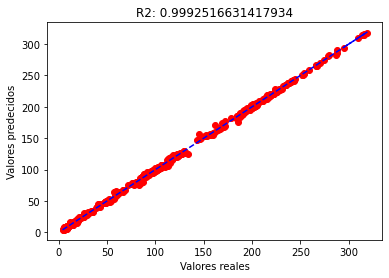

In [34]:
plot_accuracy(y, gsearch.predict(X))

### 5.1.3 Importancia de las variables predictivas en los resultados

Aquí podemos ver lo que se mencionó en la sección 4.3 en acción. Las variables más correlacionadas con el precio de la leche para el mes siguiente son el precio de la leche en el mes actual y el año, así como también las más importantes para la regresión. El mes y el trimestre no parecen influir mucho en el modelo

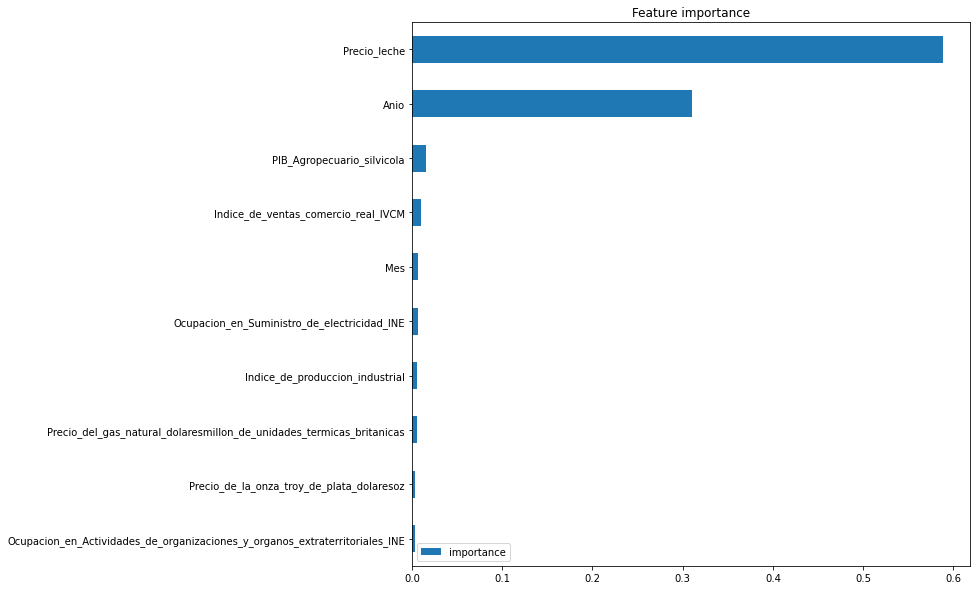

In [35]:
feature_importance = gsearch.best_estimator_.feature_importances_
feature_names = X.columns

feature_imp_df = plot_feature_importance(feature_names, feature_importance)

### 5.1.4 Visualización de la predicción

Graficamos ambos precios, los reales y las predicciones en el tiempo. Vemos como son casi idénticas

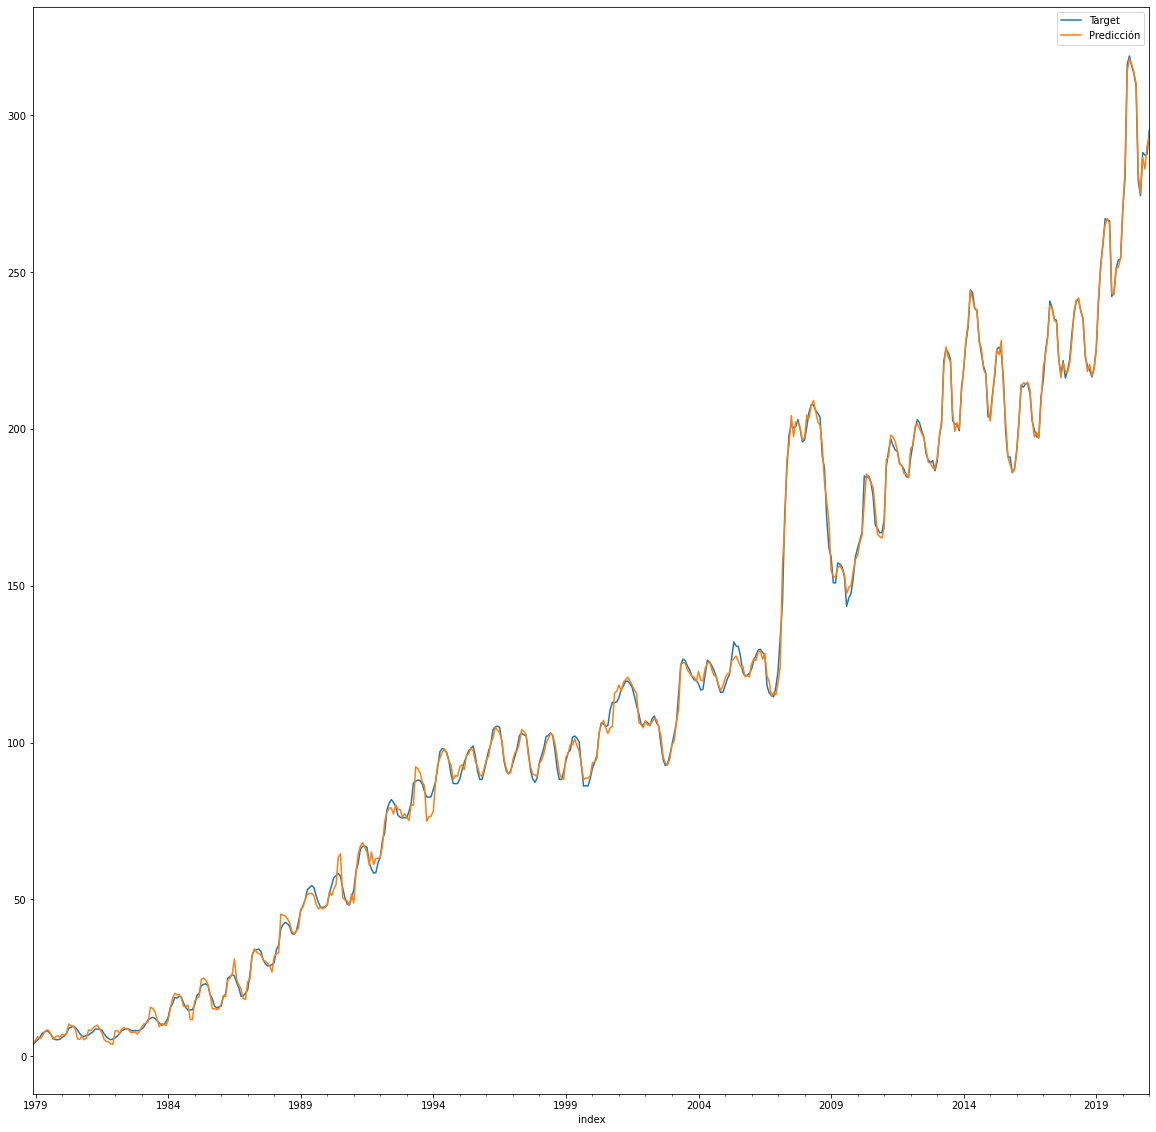

In [36]:
plot_target_and_pred(y, gsearch.predict(X))

## 5.2 XGBoost sin precio actual de la leche ni año

Podemos hacer el mismo análisis que en 5.1, pero sin las variables más importantes y vemos que la regresión de igual forma da buenos resultados

Hyperparámetros optimizados por búsqueda  por grilla:  {'max_depth': 1, 'n_estimators': 100}


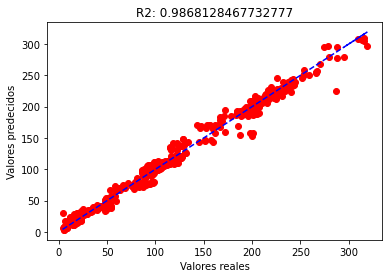

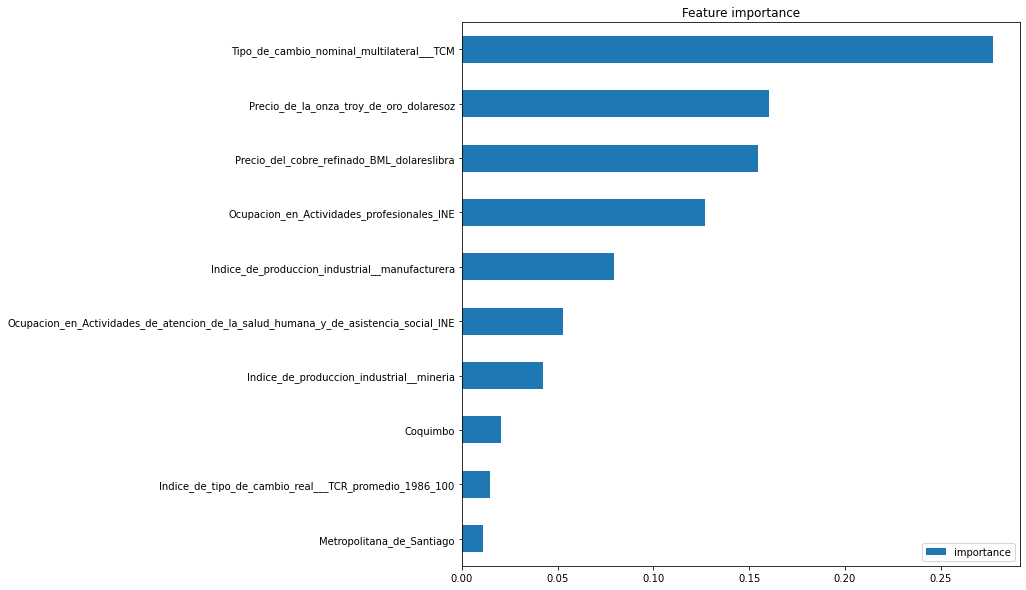

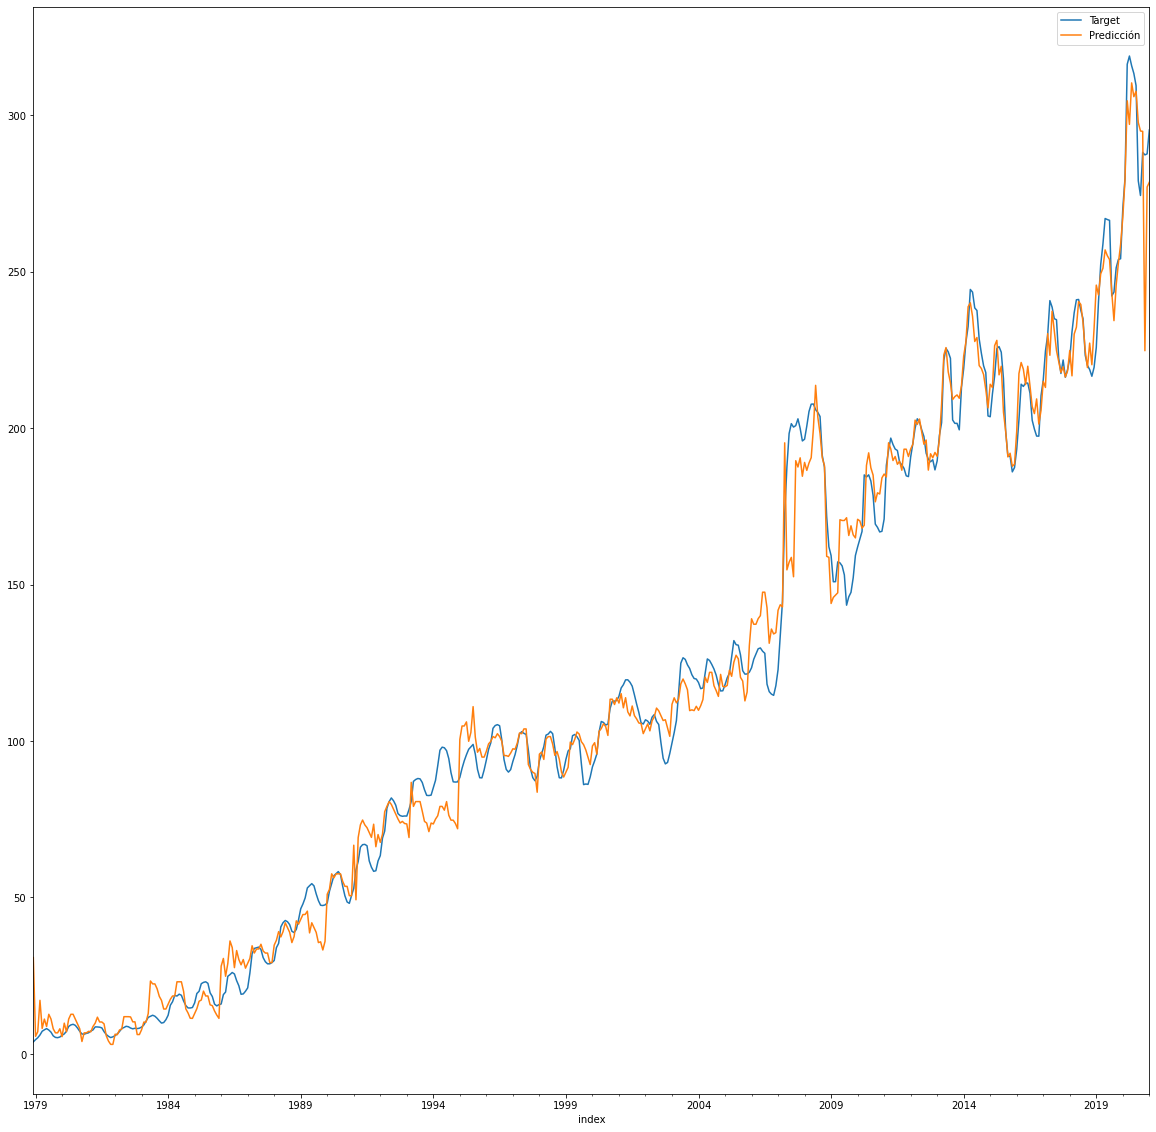

In [37]:
# features y target
X = dataset.drop(["Precio_leche", "Target", "Anio", "Mes", "Trimestre"], axis=1)

y = dataset["Target"]


model = XGBRegressor(objective='reg:squarederror')
param_search = {'max_depth' : [1, 10, 100, 1000], 'n_estimators': [1, 10, 100, 1000]}

tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=param_search, n_jobs=-1, scoring='r2', return_train_score=True)
gsearch.fit(X, y)

print("Hyperparámetros optimizados por búsqueda  por grilla: ", gsearch.best_params_)

plot_accuracy(y, gsearch.predict(X))

feature_importance = gsearch.best_estimator_.feature_importances_
feature_names = X.columns

feature_imp_df = plot_feature_importance(feature_names, feature_importance)

plot_target_and_pred(y, gsearch.predict(X))

# 6. Finalizando

Vimos que la cantidad de agua precipitada disminuye año a año. Vimos además que el precio no sufre de estacionalidad (poca correlación con el mes y trimestre del año). Por lo tanto, podríamos inferir, que los problemas de poca precipitación debido al cambio climático provocan un aumento en el precio de la leche. Esto puede ser debido al aumento de los costos de producción.

Modelos predictivos de este tipo permiten estimar la demanda de un bien o recurso. En el caso de la leche, podríamos indagar un poco más en cómo se ve afectado por la falta de recursos. Por lo tanto, estimar la demanda permitiría tomar medidas preventivas contra el abuso de recursos. Así se podría ayudar a combatir el cambio climático.

Más datos y/o más detallados sobre la producción de leche y el uso de aguas precipitadas podrían ayudar para que este modelo entregue mejores insights cómo se podrían tomar medidas para mitigar el abuso de recursos.